Neural Network based approach - Either this is implemented wrong or the ideal relationship between the input and output is linear

In [15]:
import numpy as np
import pandas as pd
import sklearn.datasets as skdata
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kl_div


from sklearn.neural_network import MLPClassifier

In [16]:
# MAKE SURE TO CHANGE THIS TO THE LOCAL PATH TO DATA
#TRAIN_PATH = "../augmented_train/reformatted_train_106800_samples.csv"
TRAIN_PATH = "../train_18120_samples_raw_consensus_1.0_balanced.csv"

data = pd.read_csv(TRAIN_PATH)

data_np = data.to_numpy()

print(data_np.shape)

(18013, 8001)


In [17]:
num_input = data_np.shape[1] - 1

x = data_np[:, 0:num_input]
y = data_np[:, num_input]

# Shuffle the dataset based on sample indices
shuffled_indices = np.random.permutation(x.shape[0])

# Choose the first 80% as training set, next 10% as validation and the rest as testing
train_split_idx = int(0.80 * x.shape[0])
val_split_idx = int(0.90 * x.shape[0])

train_indices = shuffled_indices[0:train_split_idx]
val_indices = shuffled_indices[train_split_idx:val_split_idx]
test_indices = shuffled_indices[val_split_idx:]

# Select the examples from x and y to construct our training, validation, testing sets
x_train, y_train = x[train_indices, :], y[train_indices]
x_val, y_val = x[val_indices, :], y[val_indices]
x_test, y_test = x[test_indices, :], y[test_indices]

In [18]:
regularization = [0.001] # [0.005, 0.001, 0.0001]

models = []
val_scores = []

batch_size = 64
n_iterations = 3000

CLASSES = np.unique(y)

for alpha in regularization:

    # Create an MLPClassifier instance
    model = MLPClassifier(hidden_layer_sizes=(1000, 500, 50), activation='tanh', alpha=alpha, max_iter=1)

    # Store train/validate scores to check for overfitting
    mid_train_scores = []
    mid_val_scores = []

    for i in range(n_iterations):
        # Get a mini-batch from the training set
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x_batch, y_batch = x_train[idx], y_train[idx]

        # Partially fit the model on the mini-batch
        model.partial_fit(x_batch, y_batch, classes=CLASSES)

        # Report scores every 100 iterations
        if (i + 1) % 100 == 0:
            train_score = model.score(x_train, y_train)
            val_score = model.score(x_val, y_val)
            print(f"Iteration {i+1}: Train score = {train_score:.4f}, Validation score = {val_score:.4f}")
            mid_train_scores.append(train_score)
            mid_val_scores.append(val_score)

    # Graph the train/val scores
    plt.figure(figsize=(10, 5))
    plt.plot(mid_train_scores, label='Training Scores')
    plt.plot(mid_val_scores, label='Validation Scores')
    plt.xlabel('Index')
    plt.ylabel('Scores')
    plt.title('Training and Validation Scores')
    plt.legend()
    plt.show()

    score_train = model.score(x_train, y_train)
    score_val = model.score(x_val, y_val)

    models.append(model)
    val_scores.append(score_val)

    print('Alpha = {}'.format(alpha))
    print('Training accuracy: {:0.5f}%  Validation accuracy: {:0.2f}%'.format(score_train*100, score_val*100))

# Choose the best model based on highest validation accuracy
print(val_scores)
best_model_idx = np.argmax(val_scores)
best_model = models[best_model_idx]

print('\nBest Activation: {}'.format(regularization[best_model_idx]))

# Best solver on the test set
predictions_test = best_model.predict(x_test)
score_test = best_model.score(x_test, y_test)

print("The test results.... {:0.2f}%".format(score_test*100))

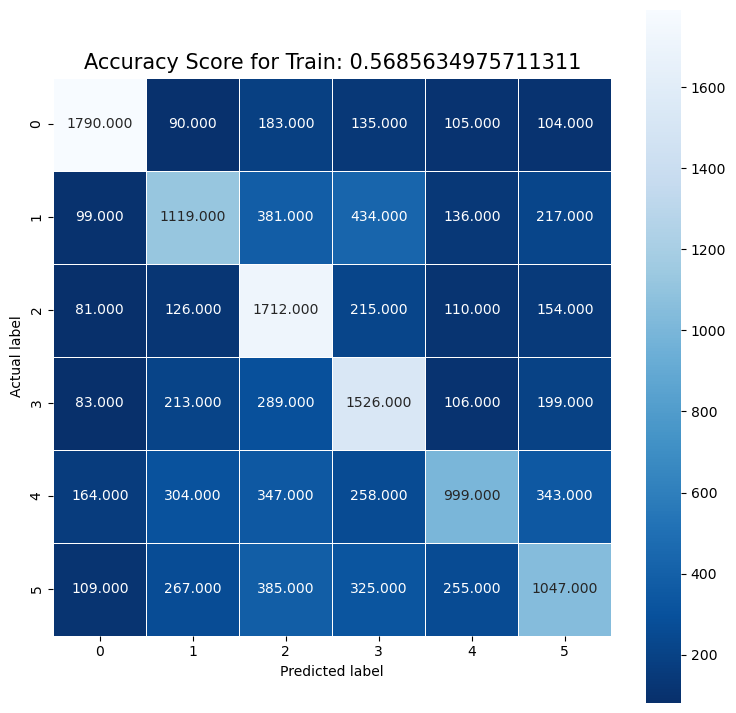

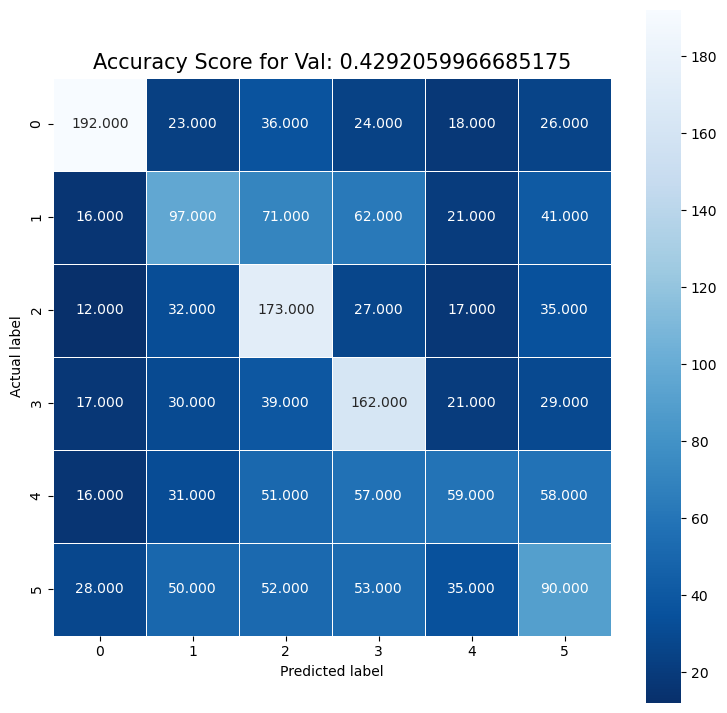

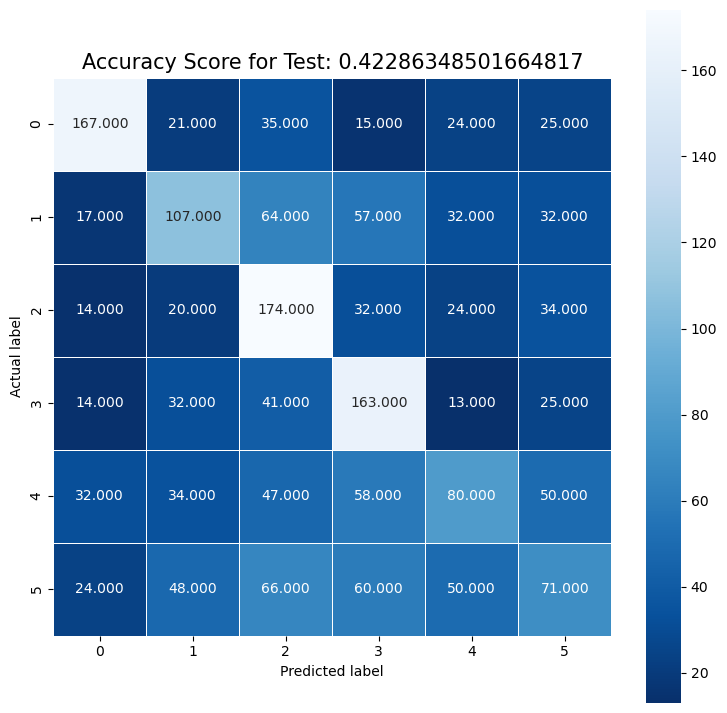

In [ ]:
best_model = models[best_model_idx]

def confusion(predictions, actual, score, set):
    cm = skmetrics.confusion_matrix(actual, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = f'Accuracy Score for {set}: {score}'
    plt.title(all_sample_title, size = 15)

confusion(best_model.predict(x_train), y_train, best_model.score(x_train, y_train), "Train")
confusion(best_model.predict(x_val), y_val, best_model.score(x_val, y_val), "Val")
confusion(best_model.predict(x_test), y_test, best_model.score(x_test, y_test), "Test")

models = []
train_scores = []
val_scores = []

num_iterations = 5

for i in range(num_iterations):
    model = MLPClassifier(hidden_layer_sizes=(1000, 1000, 1000, 6), batch_size = 100, solver = 'adam')
    model.partial_fit(x_train, y_train, classes=np.unique(y_train))

    score_train = model.score(x_train, y_train)
    train_scores.append(score_train)

    score_val = model.score(x_val, y_val)
    val_scores.append(score_val)

    models.append(model)

    print(f"Iteration {i+1}: Train accuracy: {score_train:.5f}, Val accuracy: {score_val:.5f}")

predictions_test = model.predict(x_test)
score_test = model.score(x_test, y_test)

graph()


graph()

from sklearn.metrics import confusion_matrix

def graph():
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predictions_test)
    # cm_train = confusion_matrix(y_train, predictions_train)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_scores, label='Training accuracy')
    plt.plot(val_scores, label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # plt.subplot(1, 2, 2)
    # sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()



cm = skmetrics.confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score_test)
plt.title(all_sample_title, size = 15)

predictions_train = model.predict(x_train)
cm = skmetrics.confusion_matrix(y_train, predictions_train)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score_test)
plt.title(all_sample_title, size = 15)

kullback_leibler_train = skmetrics.mutual_info_score(y_train, predictions_train)
kullback_leibler_test = skmetrics.mutual_info_score(y_test, predictions_test)

print(kullback_leibler_train)
print(kullback_leibler_test)

kl_test = kl_div()